# Computing the thermal expansion
## Introduction
A given crystal should have a well defined average lattice constant at a given pressure and temperature. Here we use silicon as an example to show how to calculate lattice constants using ``GPUMD``. 

### Importing Relevant Functions
The inputs/outputs for GPUMD are processed using the [Atomic Simulation Environment (ASE)](https://wiki.fysik.dtu.dk/ase/) and the [thermo](https://github.com/AlexGabourie/thermo) package.

In [1]:
from pylab import *
from ase.lattice.cubic import Diamond
from ase.io import write
import pandas as pd

### Preparing the Inputs
We use a cubic system (of diamond structure) consisting of $10^3\times 8 = 8000$ silicon atoms and use the minimal Tersoff potential [[Fan 2020]](https://doi.org/10.1088/1361-648X/ab5c5f).

### Generate the model.xyz file

In [2]:
Si = Diamond('Si', size=(10,10,10))
Si

Lattice(symbols='Si8000', pbc=True, cell=[54.3, 54.3, 54.3])

In [3]:
write("model.xyz", Si)

The first few lines of the model.xyz file are:
```
8000
Lattice="54.3 0.0 0.0 0.0 54.3 0.0 0.0 0.0 54.3" Properties=species:S:1:pos:R:3 pbc="T T T"
Si       0.00000000       0.00000000       0.00000000
Si       1.35750000       1.35750000       1.35750000
Si       2.71500000       2.71500000       0.00000000
Si       4.07250000       4.07250000       1.35750000
```
- Explanations for the first line:
  * The first number states that the number of particles is 8000.

- Explanations for the second line:
  * This line consists of a number of ``keyword=value`` pairs separated by spaces. Spaces before and after = are allowed. All the characters are case-insensitive.
  * ``lattice="ax ay az bx by bz cx cy cz"`` gives the box vectors.
  * ``properties=property_name:data_type:number_of_columns``. We only read the following items:
     * ``species:S:1`` atom type (Mandatory)
     * ``pos:R:3`` position vector (Mandatory)
     * ``mass:R:1`` mass (Optional: default mass values will be used when this is missing), not included here.
     * ``vel:R:3`` velocity vector (Optional), not included here.
     * ``group:I:number_of_grouping_methods`` grouping methods (Optional), not included here.

### The ``run.in`` file
The ``run.in`` input file is given below:<br>
```
potential   ../../../potentials/tersoff/Si_Fan_2019.txt
velocity    100

ensemble    npt_ber 100 100 100 0 0 0 53.4059 53.4059 53.4059 2000
time_step   1
dump_thermo 10
run         20000

ensemble    npt_ber 200 200 100 0 0 0 53.4059 53.4059 53.4059 2000
dump_thermo 10
run         20000

ensemble    npt_ber 300 300 100 0 0 0 53.4059 53.4059 53.4059 2000
dump_thermo 10
run         20000

ensemble    npt_ber 400 400 100 0 0 0 53.4059 53.4059 53.4059 2000
dump_thermo 10
run         20000

ensemble    npt_ber 500 500 100 0 0 0 53.4059 53.4059 53.4059 2000
dump_thermo 10
run         20000

ensemble    npt_ber 600 600 100 0 0 0 53.4059 53.4059 53.4059 2000
dump_thermo 10
run         20000

ensemble    npt_ber 700 700 100 0 0 0 53.4059 53.4059 53.4059 2000
dump_thermo 10
run         20000

ensemble    npt_ber 800 800 100 0 0 0 53.4059 53.4059 53.4059 2000
dump_thermo 10
run         20000

ensemble    npt_ber 900 900 100 0 0 0 53.4059 53.4059 53.4059 2000
dump_thermo 10
run         20000

ensemble    npt_ber 1000 1000 100 0 0 0 53.4059 53.4059 53.4059 2000
dump_thermo 10
run         20000
```
- The first line uses the ``potential`` keyword to define the potential to be used, which is specified in the file [Si_Fan_2019.txt](https://github.com/brucefan1983/GPUMD/blob/master/potentials/tersoff/Si_Fan_2019.txt).

- The second line uses the ``velocity`` keyword and sets the velocities to be initialized with a temperature of 100 K. 

- The following 4 lines define the first ``run``. This ``run`` will be in the NPT ``ensemble``, using the Berendsen method. The temperature is 100 K and the pressures are zero in all the directions. The coupling constants are 100 and 2000 time steps for the thermostat and the barostat. (The elastic constant, or inverse compressibility parameter needed in the barostat is estimated to be 53.4059 GPa; this only needs to be correct up to the order of magnitude.), respectively. The ``time_step` for integration is 1 fs. There are $2\times 10^4$ steps for this ``run`` and the thermodynamic quantities will be output every 10 steps. 

- After this run, there are 9 other runs with the same parameters but different target temperatures. Note that the time step only needs to be set once if one wants to use the same time step in the whole simulation. In contrast, one has to use the ``dump_thermo`` keyword for each run in order to get outputs for each run. That is, we can say that the ``time_step`` keyword is propagating and the ``dump_thermo`` keyword is non-propagating.

## Results and Discussion
Using a GeForce RTX 2080 Ti GPU, the NEMD simulation takes about 1.5 minutes. The speed of the run is about $1.6\times 10^7$ atom x step / second. 

### Figure Properties

In [4]:
aw = 2
fs = 16
font = {'size'   : fs}
matplotlib.rc('font', **font)
matplotlib.rc('axes' , linewidth=aw)

def set_fig_properties(ax_list):
    tl = 8
    tw = 2
    tlm = 4
    
    for ax in ax_list:
        ax.tick_params(which='major', length=tl, width=tw)
        ax.tick_params(which='minor', length=tlm, width=tw)
        ax.tick_params(which='both', axis='both', direction='in', right=True, top=True)

### Plot Thermal Expansion
The output file [thermo.out](https://gpumd.zheyongfan.org/index.php/The_thermo.out_output_file) contains many useful data. Here, we load the results and plot the data in the following figure.

In [5]:
data = pd.read_csv("thermo.out", delim_whitespace=True, header=None)
labels = ['T', 'K', 'U', 'Px', 'Py', 'Pz', 'Pyz', 'Pxz', 'Pxy']
# Orthogonal
if data.shape[1] == 12:
    labels += ['Lx', 'Ly', 'Lz']
elif data.shape[1] == 15:
    labels += ['ax', 'ay', 'az', 'bx', 'by', 'bz', 'cx', 'cy', 'cz']

thermo = dict()
for i in range(data.shape[1]):
    thermo[labels[i]] = data[i].to_numpy(dtype='float')

thermo.keys()


dict_keys(['T', 'K', 'U', 'Px', 'Py', 'Pz', 'Pyz', 'Pxz', 'Pxy', 'Lx', 'Ly', 'Lz'])

In [6]:
t = 0.01*np.arange(1,thermo['T'].shape[0]+1) # [ps]
NC = 10  # Number of cells in each direction
NT = 10  # Number of temperature steps
temp = np.arange(100,1001,100)
M = thermo['T'].shape[0]//NT
a = (thermo['Lx']+thermo['Ly']+thermo['Lz'])/(3*NC)
Pave = (thermo['Px']+thermo['Py']+thermo['Pz'])/3.
a_ave = a.reshape(NT, M)[:,M//2+1:].mean(axis=1)
fit = np.poly1d(np.polyfit(temp, a_ave, deg=1))

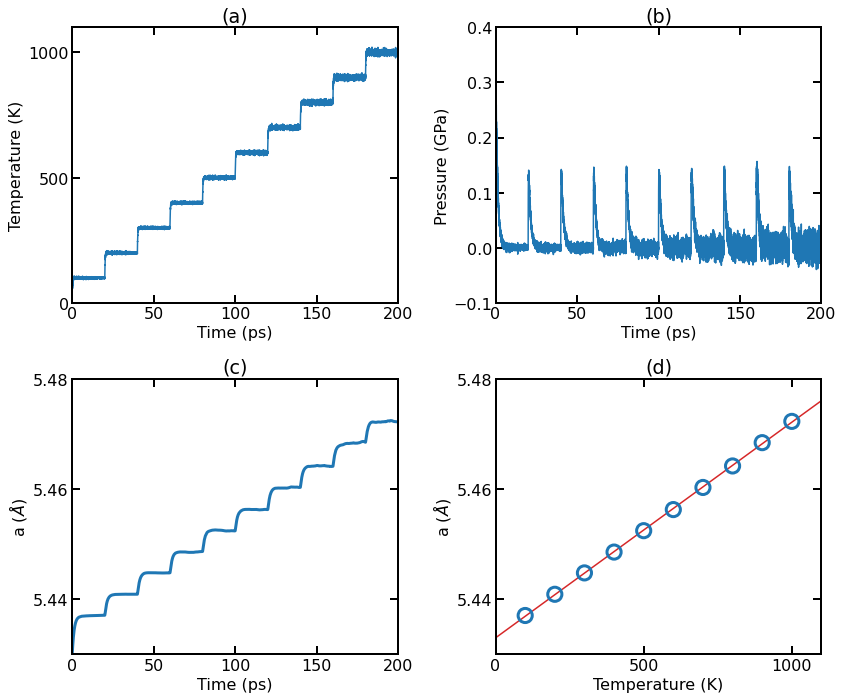

In [7]:
figure(figsize=(12,10))
subplot(2,2,1)
set_fig_properties([gca()])
plot(t, thermo['T'])
xlim([0, 200])
gca().set_xticks(range(0,201,50))
ylim([0, 1100])
gca().set_yticks(range(0,1101,500))
ylabel('Temperature (K)')
xlabel('Time (ps)')
title('(a)')

subplot(2,2,2)
set_fig_properties([gca()])
plot(t, Pave)
xlim([0, 200])
gca().set_xticks(range(0,201,50))
ylim([-0.1, 0.4])
gca().set_yticks(np.arange(-1,5)/10)
ylabel('Pressure (GPa)')
xlabel('Time (ps)')
title('(b)')

subplot(2,2,3)
set_fig_properties([gca()])
plot(t, a,linewidth=3)
xlim([0, 200])
gca().set_xticks(range(0,201,50))
ylim([5.43, 5.48])
gca().set_yticks([5.44,5.46,5.48])
ylabel(r'a ($\AA$)')
xlabel('Time (ps)')
title('(c)')

subplot(2,2,4)
set_fig_properties([gca()])
Tpoly = [0, 1100]
plot(Tpoly, fit(Tpoly),color='C3')
scatter(temp, a_ave,s=200,zorder=100,facecolor='none',edgecolors='C0',linewidths=3)
xlim([0, 1100])
gca().set_xticks(range(0,1101,500))
ylim([5.43, 5.48])
gca().set_yticks([5.44,5.46,5.48])
ylabel(r'a ($\AA$)')
xlabel('Temperature (K)')
title('(d)')

tight_layout()
show()

**(a)** Instant temperature as a function of simulation time. **(b)** Instant pressure as a function of simulation time. **(c)** Instant lattice constant as a function of simulation time. **(d)** Averaged lattice constant (over the last 10 ps in each run for a given temperature) as a function of temperature.

Additional figure notes:<br>

- (a): The temperature for each run quickly reaches the target temperature (with fluctuations).

- (b): The pressure (averaged over the three directions) for each run quickly reaches the target pressure zero (with fluctuations).

- (c): The lattice constant (averaged over the three directions) for each run reaches a plateau (with fluctuations) after some steps.

- (d): We calculate the average lattice constant at each temperature by averaging the second half of the data for each run. The average lattice constants at different temperatures can be well fit by a linear function, with the thermal expansion coefficient being estimated to be $\alpha \approx 7.2 \times 10^{-6}$ K<sup>-1</sup>.

## References
[Fan 2020] Zheyong Fan, Yanzhou Wang, Xiaokun Gu, Ping Qian, Yanjing Su, and Tapio Ala-Nissila, [A minimal Tersoff potential for diamond silicon with improved descriptions of elastic and phonon transport properties](https://doi.org/10.1088/1361-648X/ab5c5f), J. Phys.: Condens. Matter **32** 135901 (2020).